<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Used-Python-Libraries" data-toc-modified-id="Used-Python-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Used Python Libraries</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Example-Images" data-toc-modified-id="Example-Images-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Example Images</a></span></li></ul></li><li><span><a href="#Working-with-Image-Data" data-toc-modified-id="Working-with-Image-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Working with Image Data</a></span><ul class="toc-item"><li><span><a href="#Feature-Reduction-with-PCA" data-toc-modified-id="Feature-Reduction-with-PCA-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Feature Reduction with PCA</a></span></li></ul></li><li><span><a href="#Modeling-with-XGBoost" data-toc-modified-id="Modeling-with-XGBoost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling with XGBoost</a></span></li><li><span><a href="#Interactive-Visualization-of-Results" data-toc-modified-id="Interactive-Visualization-of-Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Interactive Visualization of Results</a></span></li></ul></div>

## Objective

mmmm

[Back to Contents](#Table-of-Contents)

## Used Python Libraries

In [528]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image
from PIL import Image, ImageDraw

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from progressbar import Percentage, ProgressBar,Bar,ETA


[Back to Contents](#Table-of-Contents)

## Load Data

A table in csv format is provided to identify the expert diagnosis label and the associated image label.

In [15]:
training_labels_df = pd.read_csv('./data/train_labels.csv')
print(training_labels_df.shape)
training_labels_df.sample(6)

(220025, 2)


,id,label
45978,bf65313aa3cbd07407f4af49ecbde6f218dcfdab,0
193647,893b00b27dea8eb9fdf11c01d44f0e09d89c4427,1
93517,52ab703f9ce89055cc7accd7feb20025d7749fe7,1
71744,47ab7d719e7630403b6aba72cb71981b5f455189,0
87347,5e107121ffcde79d817c5e8f8ad7209c4a963dd8,1
197361,98940b7fe58f6fd2f64b60e2d529007bce878d9c,0


In [16]:
# Any duplicated exemplar?
any(training_labels_df.duplicated())

False

In [21]:
pd.DataFrame({'label': training_labels_df['label'].value_counts(), 
              'label (perc.)': 100*training_labels_df['label'].value_counts()/len(training_labels_df)})

,label,label (perc.)
0,130908,59.496875
1,89117,40.503125


In [120]:
# image location
img_path ="./data/train"
# bounding box where identification neds to happen
ix1, iy1, ix2, iy2 = 47-16, 47-16, 47+16, 47+16

[Back to Contents](#Table-of-Contents)

### Example Images

In [121]:
def plot_images(label, img_path = "./data/train", rows_cols = (3,3), rnd_state=0):
    nrows, ncols=rows_cols[0], rows_cols[1]
    
    np.random.seed(rnd_state)
    imgs = np.random.choice(training_labels_df.loc[training_labels_df['label']==label]['id'].values, 
                            size=np.prod(rows_cols))
    fig,ax = plt.subplots(nrows,ncols,figsize=(10,10))
    fig.suptitle('Examples of Label=' + str(label) + ' Images', fontsize=25)
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(imgs[:nrows*ncols]):
        fname = os.path.join(img_path ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='red') # each image has 96pxx96px
        idcol.rectangle(((ix1,iy1),(ix2,iy2)),outline='green')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')  

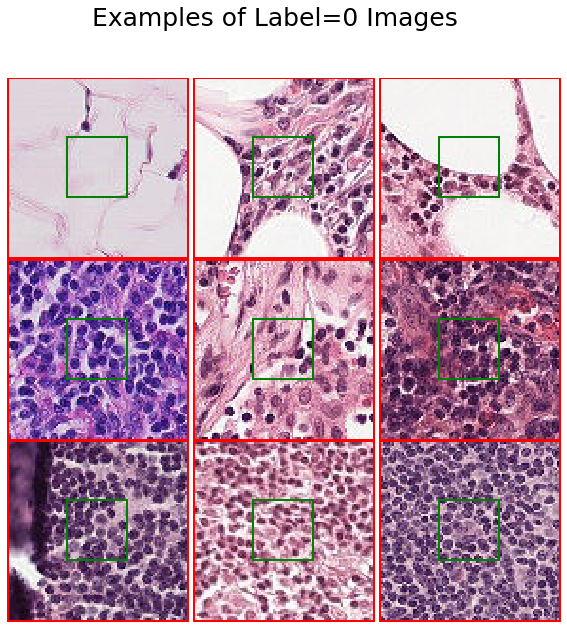

In [122]:
plot_images(0)

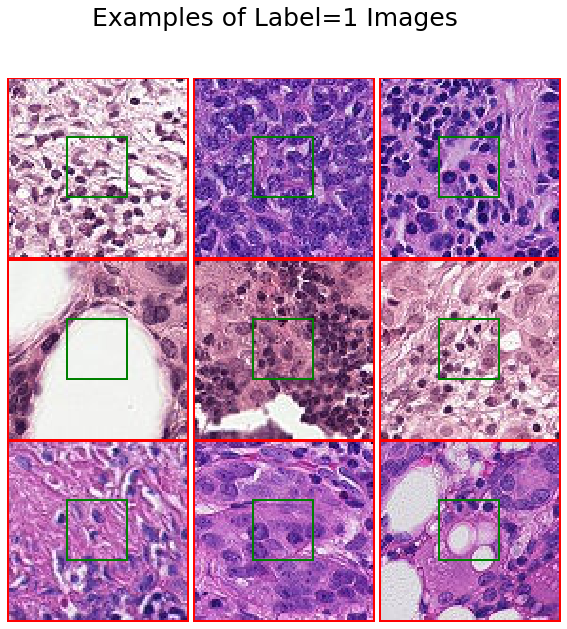

In [123]:
plot_images(1)

[Back to Contents](#Table-of-Contents)

## Working with Image Data

In [78]:
print('An image can be converted to an array of size:', 
      np.array(Image.open(os.path.join(img_path ,training_labels_df.iloc[0]['id'] +'.tif'))).shape)


An image can be converted to an array of size: (96, 96, 3)


Let's take two random images, one with label=1 and the other with label=0. Can we separate them ...?

In [414]:
np.random.seed(1)

imgs_0 = np.array(Image.open(os.path.join(img_path ,
                                          np.random.choice(training_labels_df.loc[training_labels_df['label']==0]['id'].values, size=1)[0]) +'.tif'))

imgs_1 = np.array(Image.open(os.path.join(img_path ,
                                          np.random.choice(training_labels_df.loc[training_labels_df['label']==1]['id'].values, size=1)[0]) +'.tif'))


In [415]:
np.ravel(imgs_0[ix1:ix2,iy1:iy2,1]).shape, np.ravel(imgs_1[ix1:ix2,iy1:iy2,1]).shape

print('When we consider the central part of the image of size', ix2-ix1, 'px X', iy2-iy1, 'px',
     'the size of one exemplar becomes', np.ravel(imgs_0[ix1:ix2,iy1:iy2,1]).shape)

When we consider the central part of the image of size 32 px X 32 px the size of one exemplar becomes (1024,)


### Feature Reduction with PCA

In [395]:
weights = compute_class_weight('balanced', np.unique(training_labels_df.label), training_labels_df.label)

/Users/atambu310/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=0         0
1         1
2         0
3         0
4         0
         ..
220020    0
220021    1
220022    0
220023    0
220024    1
Name: label, Length: 220025, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [398]:
np.random.seed(1)

n_imgs = 1000

# assign same probability to be picked or keep existing count ratio
p_0 = weights[0]
p_1 = weights[1]
p_s = np.array([p_0 if i==0 else p_1 for i in training_labels_df['label']])
p_s = p_s/np.sum(p_s)

lbls_i_s = np.random.choice(range(len(training_labels_df['id'].values)), 
                          p = p_s,
                          size=n_imgs)
imgs_s = [training_labels_df['id'].values[i] for i in lbls_i_s]
lbls_s = [training_labels_df['label'].values[i] for i in lbls_i_s]

imgs_np_s = np.array([])
pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                   maxval=len(imgs_s)).start()
k = 0
for i,j in enumerate(imgs_s):
    fname = os.path.join(img_path ,j +'.tif')
    img = Image.open(fname)
    if len(imgs_np_s)==0:
        imgs_np_s = np.ravel(np.array(img)[ix1:ix2,iy1:iy2,:])[:,None]/255.
    else:
        imgs_np_s = np.concatenate([imgs_np_s, np.ravel(np.array(img)[ix1:ix2,iy1:iy2,:])[:,None]/255], axis=1)
    k += 1
    pbar.update(k)
pbar.finish()
   
imgs_np_s = imgs_np_s.T    

imgs_np_s.shape

[==========================================================] 100% Time: 0:00:10


(1000, 3072)

In [399]:
np.unique(lbls_s, return_counts=True)

(array([0, 1]), array([495, 505]))

In [400]:
# take all components needed to cover 90% of variance
pca_pipeline = make_pipeline(StandardScaler(), PCA(0.9, random_state=2)) 

In [401]:
components = pca_pipeline.fit_transform(imgs_np_s)
projected = pca_pipeline.inverse_transform(components)
print(components.shape)

(1000, 229)


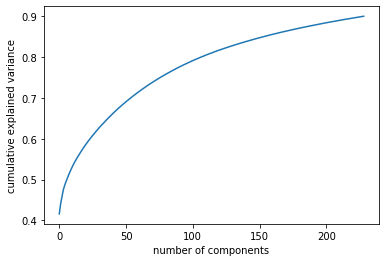

In [402]:
plt.plot(np.cumsum(pca_pipeline['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


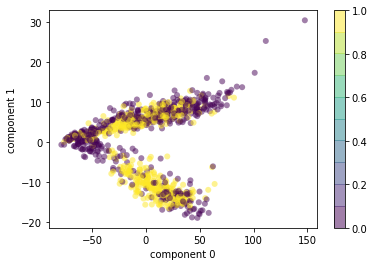

In [403]:
comps = (0,1)

plt.scatter(components[:, comps[0]], components[:, comps[1]],
            c=lbls_s, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component '+str(comps[0]))
plt.ylabel('component '+str(comps[1]))
plt.colorbar();

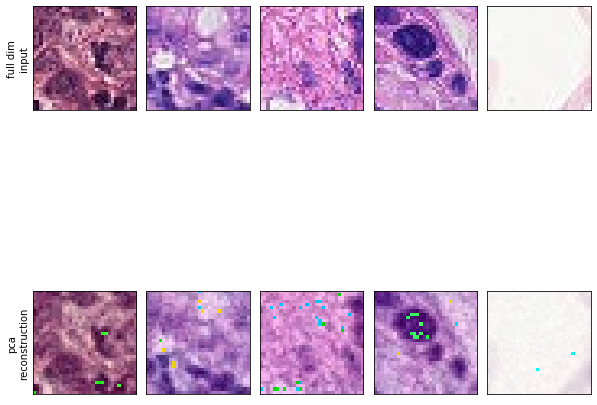

In [404]:
# Plot the PCA reconstruction
fig, ax = plt.subplots(2, 5, figsize=(10, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(5):
    ax[0, i].imshow((255*imgs_np_s[i,:]).astype('uint8').reshape(32,32,3), cmap='binary_r')
    ax[1, i].imshow((255*projected[i]).astype('uint8').reshape(32,32,3), cmap='binary_r')
    
ax[0, 0].set_ylabel('full dim\ninput')
ax[1, 0].set_ylabel('pca\nreconstruction');


[Back to Contents](#Table-of-Contents)

## Modeling with XGBoost

We'll trin xgboost incrementally since the data is too large to be efficiently used

In [496]:
def getBatchData(img_names, verbose=False):
    imgs_np = np.array([])
    if verbose:
        pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                           maxval=len(img_names)).start()
    k = 0
    for i,j in enumerate(img_names):
        fname = os.path.join(img_path ,j +'.tif')
        img = Image.open(fname)
        if len(imgs_np)==0:
            imgs_np = np.ravel(np.array(img)[ix1:ix2,iy1:iy2,:])[:,None]/255.
        else:
            imgs_np = np.concatenate([imgs_np, np.ravel(np.array(img)[ix1:ix2,iy1:iy2,:])[:,None]/255], axis=1)
        k += 1
        if verbose:
            pbar.update(k)
    if verbose:
        pbar.finish()

    imgs_np = imgs_np.T    
    
    return imgs_np

In [488]:
train_labels_df, test_labels_df = train_test_split(training_labels_df, test_size=0.25, 
                                                   stratify=training_labels_df.label, random_state=10)

In [494]:
#test data
img_names = test_labels_df['id'].values[:1000]
X_test = getBatchData(img_names)
y_test = test_labels_df['label'].values[:1000]    

[==========================================================] 100% Time: 0:00:09


In [492]:
# create random batches from **training data**
n_splits = 100
max_batch_size = 1000

# assign same probability to be picked 
weights = compute_class_weight('balanced', np.unique(train_labels_df.label), train_labels_df.label)
p_0 = weights[0]
p_1 = weights[1]
p_s = np.array([p_0 if i==0 else p_1 for i in train_labels_df['label']])
p_s = p_s/np.sum(p_s)

print('Generating', n_splits, 'balanced random batches of size', max_batch_size)

Generating 100 balanced random batches of size 1000


In [510]:
def generate_rf(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=5, min_samples_leaf=3)
    rf.fit(X_train, y_train)
    print "rf score ", rf.score(X_test, y_test)
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a


'0.90'

In [538]:
#results = {}

results = []
model = RandomForestClassifier(n_estimators=5, min_samples_leaf=3, 
                               class_weight='balanced', random_state=42, n_jobs=-1)
k = 0
for i in range(n_splits):
    lbls_i_s = np.random.choice(range(len(train_labels_df['id'].values)), 
                              p = p_s,
                              size=max_batch_size)
    
    print('-->Batch:', k)
    print('Ratios for 0/1 labels:', np.unique(lbls_s, return_counts=True)[1]/len(lbls_s))
    
    #training batch
    img_names = [train_labels_df['id'].values[i] for i in lbls_i_s]
    print('Getting batch...')
    X_train = getBatchData(img_names)
    y_train = [train_labels_df['label'].values[i] for i in lbls_i_s]
    print('...done')
     
    #feature reduction
    print('PCA...')
    pca_pipeline = make_pipeline(StandardScaler(), PCA(100, random_state=2)) #fix number of features
    X_train = pca_pipeline.fit_transform(X_train)
    ##pca transformation changes from batch to batch, so update test set accordingly
    X_test_tmp = pca_pipeline.transform(X_test)
    print('...done')
    
    #train model
    print('Model training...')
    
    #xgboost
    #dtrain = xgb.DMatrix(X_train, y_train)
    #dtest = xgb.DMatrix(X_test_tmp, y_test)
    #model_tmp = xgb.train({
    #            'learning_rate': 0.1,
    #            'eval_metric': 'auc',
    #            'seed': 42,
    #            'updater':'refresh',
    #            'process_type': 'update',
    #            'refresh_leaf': True,
    #            'silent': False
    #}, 
    #        dtrain=dtrain, 
    #        evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
    #        early_stopping_rounds=5,
    #        xgb_model=model)   

    #model_tmp = XGBClassifier(objective="binary:logistic", 
    #                          eval_metric="auc",
    #                          n_jobs=-1,
    #                          xgb_model=model, #keep updating model
    #                          random_state=42)
    #model_tmp.fit(X_train,y_train, early_stopping_rounds=5, eval_set=[(X_test_tmp, y_test)], verbose=0)
    
    model.fit(X_train, y_train)
    
    print('...done')
    #y_pred = model_tmp.predict(X_test_tmp)
    #y_pred = (model_tmp.predict(dtest)>0.5).astype(int)
    y_pred = model.predict(X_test_tmp)
    #model = model_tmp
    
    if model.n_estimators < 1000:
        model.estimators_ += model.estimators_
        model.n_estimators = len(model.estimators_)
    
    
    print('current model:', model.n_estimators)
    
    cm = confusion_matrix(y_test, y_pred)
    auc   = roc_auc_score(y_test, y_pred)
    acc   = accuracy(y_test, y_pred)
    rec   = recall(y_test, y_pred)
    prec  = precision(y_test, y_pred)
    f1    = f1_score(y_test, y_pred)

    print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}, AUC = {auc}')
    print('Confusion Matrix is:')
    print(cm)

    results.append(auc)
    
    if len(results)>5 and np.max(results[-5:]) - np.min(results[-5:])<0.1:
        break
    #results.update({'RF'+str(k): [acc, rec, prec, f1, auc]})

    #if k==1:
    #    break
    k+=1

-->Batch: 0
Ratios for 0/1 labels: [0.498 0.502]
Getting batch...
...done
PCA...
...done
Model training...
...done
current model: 10
Accuracy = 0.621, Precision = 0.5283018867924528, Recall = 0.684596577017115, F1-score = 0.5963791267305645, AUC = 0.6307923663427368
Confusion Matrix is:
[[341 250]
 [129 280]]
-->Batch: 1
Ratios for 0/1 labels: [0.498 0.502]
Getting batch...
...done
PCA...
...done
Model training...
...done
current model: 20
Accuracy = 0.661, Precision = 0.5688976377952756, Recall = 0.706601466992665, F1-score = 0.6303162486368593, AUC = 0.6680215456790736
Confusion Matrix is:
[[372 219]
 [120 289]]
-->Batch: 2
Ratios for 0/1 labels: [0.498 0.502]
Getting batch...
...done
PCA...
...done
Model training...
...done
current model: 40
Accuracy = 0.684, Precision = 0.5850091407678245, Recall = 0.78239608801956, F1-score = 0.6694560669456068, AUC = 0.6991506666832148
Confusion Matrix is:
[[364 227]
 [ 89 320]]
-->Batch: 3
Ratios for 0/1 labels: [0.498 0.502]
Getting batch...
..

In [537]:
[0,1,2,3,4][-2:]


[3, 4]

[Back to Contents](#Table-of-Contents)